In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../..')

In [3]:
import deepmatcher as dm
from utils.intermediate_layer_extraction import returnLayerInputUnlabeled,return_layer_input
from utils.ri_calculator import computeRi
import pandas as pd
import torch

## Dataset creation with hybrid model

In [4]:
import pandas as pd
DATASET_DIR = '../../datasets/Structured/DBLP-GoogleScholar/'
test_df = pd.read_csv(DATASET_DIR+'merged_test.csv')
test_df[test_df.label==1].to_csv(DATASET_DIR+'test_positives.csv',index=False)
test_df[test_df.label==0].to_csv(DATASET_DIR+'test_negatives.csv',index=False)

In [11]:
attributes = ['title','authors','venue','year']

In [6]:
hybrid_model = dm.MatchingModel(attr_summarizer='hybrid')
hybrid_model.load_state('../../models/dblp_scholar_hybrid.pth')
hybrid_model = hybrid_model.cuda()

In [9]:
testneg = return_layer_input(hybrid_model,hybrid_model.classifier,
                             DATASET_DIR,'test_negatives')


Reading and processing data from "../../datasets/Structured/DBLP-GoogleScholar/test_negatives.csv"
0% [############################# ] 100% | ETA: 00:00:00

In [7]:
testpos = return_layer_input(hybrid_model,hybrid_model.classifier,
                             DATASET_DIR,'test_positives')


Reading and processing data from "../../datasets/Structured/DBLP-GoogleScholar/test_positives.csv"
0% [############################# ] 100% | ETA: 00:00:00

In [19]:
positives = returnLayerInputUnlabeled(hybrid_model,hybrid_model.classifier,
                               '../../datasets/Structured/DBLP-ACM/','positives')


Reading and processing data from "../../datasets/Structured/DBLP-ACM/positives.csv"
0% [############################# ] 100% | ETA: 00:00:00

In [20]:
negatives = returnLayerInputUnlabeled(hybrid_model,hybrid_model.classifier,
                               '../../datasets/Structured/DBLP-ACM/','negatives')


Reading and processing data from "../../datasets/Structured/DBLP-ACM/negatives.csv"
0% [############################# ] 100% | ETA: 00:00:00

In [12]:
## Basta scegliere un campione a caso
classifier_len = len(list(testneg.values())[0])
attribute_len = int(classifier_len/len(attributes))

## Ri discovery

### Negatives

In [13]:
neg_ri,neg_ri_norms = computeRi(hybrid_model.classifier,attributes,testneg,0)
torch.save(neg_ri,'experiment_results/testneg_ri_hybrid.pt')

100%|██████████| 4672/4672 [24:56<00:00,  3.12it/s]


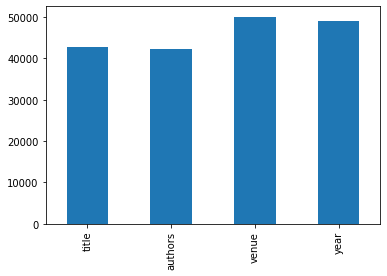

In [15]:
neg_ri_norms.sum(numeric_only=True).plot.bar()

In [22]:
neg_ri_norms.to_csv('experiment_results/testneg_ri_norms.csv',index=False)

### Positives

In [16]:
testpos_ri,testpos_ri_norms = computeRi(hybrid_model.classifier,attributes,testpos,1)
torch.save(testpos_ri,'experiment_results/testpos_ri_hybrid.pt')

100%|██████████| 1070/1070 [03:48<00:00,  4.68it/s]


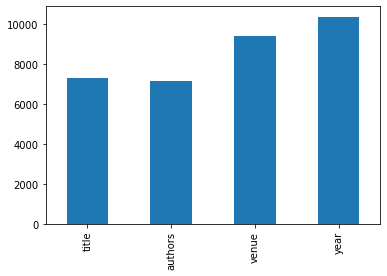

In [17]:
testpos_ri_norms.sum().plot.bar()

In [18]:
testpos_ri_norms.to_csv('experiment_results/testpos_ri_norms.csv',index=False)

## Nearest neighbors discovery

In [16]:
from utils.distance_measures import nearestNeighborsOnAttribute

In [41]:
neg_ri = torch.load('experiment_results/testneg_ri_hybrid.pt')
pos_ri = torch.load('experiment_results/testpos_ri_hybrid.pt')

In [49]:
negatives_closer_vectors_df = nearestNeighborsOnAttribute(testneg,neg_ri,positives,attributes,attribute_len,
                                                         min_similarity=0)


100%|██████████| 2029/2029 [00:06<00:00, 306.23it/s]


In [22]:
negatives_closer_vectors_df.to_csv('experiment_results/testnegNNHybrid_filtered.csv',index=False)

In [29]:
positives_closer_vectors_df = nearestNeighborsOnAttribute(testpos,pos_ri,negatives,
                                                                      attributes,attribute_len,
                                                                       min_similarity=0)

100%|██████████| 444/444 [00:02<00:00, 162.42it/s]


In [30]:
positives_closer_vectors_df.to_csv('experiment_results/testposNNHybrid_filtered.csv',index=False)

## Test

In [24]:
import torch.nn.functional as F

In [36]:
from utils.ri_calculator import findPerturbationToFlipPredict

In [31]:
hybrid_model = dm.MatchingModel(attr_summarizer='hybrid')
hybrid_model.load_state('../../models/dblp_acm_hybrid.pth')
##hybrid_model = hybrid_model.cuda()

In [32]:
testpos = returnLayerInputUnlabeled(hybrid_model,
                             '../../datasets/Structured/DBLP-ACM/','test_positives')


Reading and processing data from "../../datasets/Structured/DBLP-ACM/test_positives.csv"
0% [############################# ] 100% | ETA: 00:00:00

In [33]:
pos_ri,pos_ri_norms = computeRi(hybrid_model.classifier,attributes,testpos,1)

100%|██████████| 444/444 [02:01<00:00,  3.65it/s]


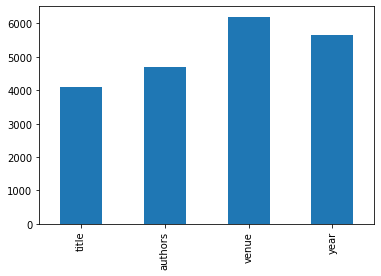

In [35]:
pos_ri_norms.sum().plot.bar()

In [44]:
train_df = pd.read_csv('../../datasets/Structured/DBLP-ACM/merged_train.csv')

In [53]:
DATASET_DIR ='../../datasets/Structured/DBLP-ACM/'
testpos_dm = dm.data.process_unlabeled(DATASET_DIR+'merged_test.csv',hybrid_model,
                                      ignore_columns=['label','id'])


Reading and processing data from "../../datasets/Structured/DBLP-ACM/merged_test.csv"
0% [############################# ] 100% | ETA: 00:00:00

In [54]:
true_pred = hybrid_model.run_prediction(testpos_dm)

===>  PREDICT Epoch 8


0% [███████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:15


Finished Epoch 8 || Run Time:    7.2 | Load Time:    8.5 || F1:   0.00 | Prec:   0.00 | Rec:   0.00 || Ex/s:   0.00



In [55]:
testpos_fake = dm.data.process(DATASET_DIR,train='merged_test.csv',left_prefix='ltable_',
                               right_prefix='rtable_')


Reading and processing data from "../../datasets/Structured/DBLP-ACM/merged_test.csv"
0% [############################# ] 100% | ETA: 00:00:00
Building vocabulary
0% [###] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00

Computing principal components
0% [###] 100% | ETA: 00:00:00
Total time elapsed: 00:00:03


In [56]:
fake_pred =hybrid_model.run_prediction(testpos_fake)

===>  PREDICT Epoch 8


0% [███████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:14


Finished Epoch 8 || Run Time:    7.2 | Load Time:    8.3 || F1:  98.22 | Prec:  96.93 | Rec:  99.55 || Ex/s: 159.50



In [59]:
for p1,p2 in zip(true_pred.match_score.values,fake_pred.match_score.values):
    if p1!=p2:
        print((p1,p2))

In [68]:
testpos2 = returnLayerInputUnlabeled(hybrid_model,hybrid_model.classifier,
                               '../../datasets/Structured/DBLP-ACM/','test_positives')


Reading and processing data from "../../datasets/Structured/DBLP-ACM/test_positives.csv"
0% [############################# ] 100% | ETA: 00:00:00

In [69]:
pos_ri2,pos_ri_norms2 = computeRi(hybrid_model.classifier,attributes,testpos2,1)

100%|██████████| 444/444 [01:50<00:00,  4.02it/s]


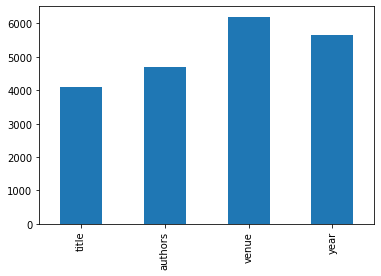

In [70]:
pos_ri_norms2.sum().plot.bar()

In [75]:
hybrid_model2 = dm.MatchingModel(attr_summarizer='hybrid')
hybrid_model2.load_state('../../models/dblp_acm_hybrid2.pth')
hybrid_model2 = hybrid_model2.cuda()

In [76]:
testpos2i = returnLayerInputUnlabeled(hybrid_model2,hybrid_model2.classifier,
                               '../../datasets/Structured/DBLP-ACM/','test_positives')


Reading and processing data from "../../datasets/Structured/DBLP-ACM/test_positives.csv"
0% [############################# ] 100% | ETA: 00:00:00

In [77]:
pos_ri2i,pos_ri_norms2i = computeRi(hybrid_model2.classifier,attributes,testpos2i,1)

100%|██████████| 444/444 [01:33<00:00,  4.77it/s]


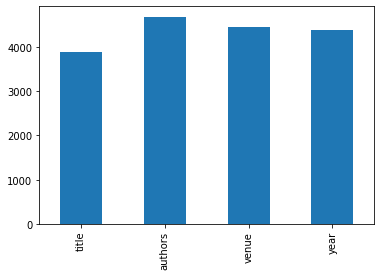

In [78]:
pos_ri_norms2i.sum().plot.bar()

In [84]:
testpos2 = return_layer_input(hybrid_model2,hybrid_model2.classifier,
                               '../../datasets/Structured/DBLP-ACM/','test_positives')


Reading and processing data from "../../datasets/Structured/DBLP-ACM/test_positives.csv"
0% [############################# ] 100% | ETA: 00:00:00
Building vocabulary
0% [#] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00

Computing principal components
0% [#] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00


In [80]:
pos_ri2,pos_ri_norms2 = computeRi(hybrid_model2.classifier,attributes,testpos2,1)

100%|██████████| 444/444 [00:34<00:00, 12.70it/s]


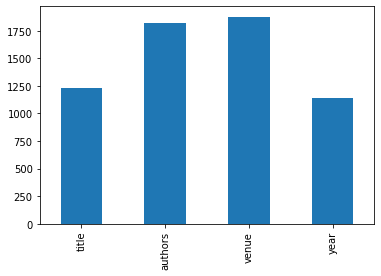

In [81]:
pos_ri_norms2.sum().plot.bar()

In [85]:
for key in testpos2i.keys():
    print(torch.norm(testpos2i[key]-testpos2[key]).item())

6.013233184814453
8.419266700744629
9.470592498779297
8.061202049255371
4.736684322357178
6.25020694732666
4.709441661834717
6.483670234680176
9.034685134887695
5.926397323608398
4.675487995147705
13.26247787475586
5.47933292388916
9.156543731689453
9.064640998840332
6.102056980133057
7.952148914337158
4.849846839904785
9.036534309387207
8.94332218170166
8.74321460723877
9.277305603027344
4.465804576873779
6.67368221282959
4.870484828948975
8.166108131408691
6.78516960144043
7.0671796798706055
6.238358497619629
5.6928229331970215
6.983000755310059
6.9819207191467285
8.705131530761719
8.294671058654785
6.280832767486572
7.795933723449707
4.404969692230225
8.770273208618164
4.785650730133057
15.0551176071167
5.213739395141602
7.840186595916748
5.192795276641846
5.6423444747924805
6.667527675628662
6.302277088165283
7.956787109375
8.065790176391602
8.967409133911133
5.121453762054443
7.614959239959717
5.855052471160889
9.125483512878418
8.416068077087402
6.292396545410156
5.88225793838501

In [86]:
testpos2i.keys()==testpos2.keys()

True